In [3]:
import os
# if using Apple MPS, fall back to CPU for unsupported ops
os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] = "1"
import numpy as np
import torch
import matplotlib.pyplot as plt
from PIL import Image

In [6]:
# select the device for computation
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")
print(f"using device: {device}")

if device.type == "cuda":
    # use bfloat16 for the entire notebook
    torch.autocast("cuda", dtype=torch.bfloat16).__enter__()
    # turn on tfloat32 for Ampere GPUs (https://pytorch.org/docs/stable/notes/cuda.html#tensorfloat-32-tf32-on-ampere-devices)
    if torch.cuda.get_device_properties(0).major >= 8:
        torch.backends.cuda.matmul.allow_tf32 = True
        torch.backends.cudnn.allow_tf32 = True
elif device.type == "mps":
    print(
        "\nSupport for MPS devices is preliminary. SAM 2 is trained with CUDA and might "
        "give numerically different outputs and sometimes degraded performance on MPS. "
        "See e.g. https://github.com/pytorch/pytorch/issues/84936 for a discussion."
    )

using device: cuda


In [10]:
from sam2.build_sam import build_sam2_video_predictor

sam2_checkpoint = "segment-anything-2/checkpoints/sam2_hiera_tiny.pt"
model_cfg = "sam2_hiera_t"

predictor = build_sam2_video_predictor(model_cfg, sam2_checkpoint, device=device)

In [7]:
def show_mask(mask, ax, obj_id=None, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        cmap = plt.get_cmap("tab10")
        cmap_idx = 0 if obj_id is None else obj_id
        color = np.array([*cmap(cmap_idx)[:3], 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)


def show_points(coords, labels, ax, marker_size=200):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)


def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0, 0, 0, 0), lw=2))

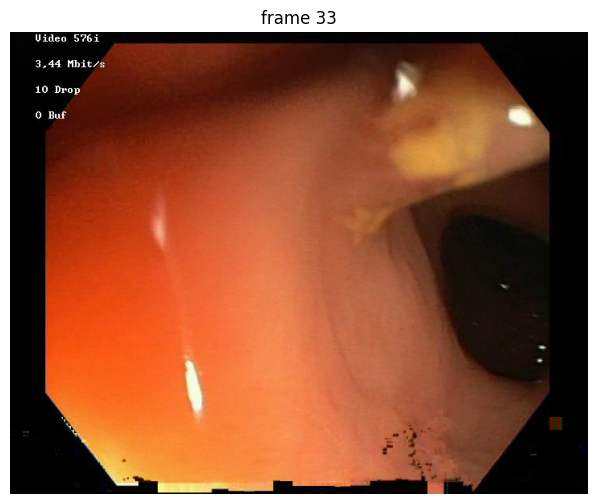

In [33]:
import os
from PIL import Image
import matplotlib.pyplot as plt

# Directory of JPEG frames
video_dir = "C:/Users/39327/Desktop/test/output_frames_first2"

# Scan all the JPEG frame names in this directory
frame_names = [
    p for p in os.listdir(video_dir)
    if os.path.splitext(p)[-1].lower() in [".jpg", ".jpeg"]
]
frame_names.sort(key=lambda p: int(os.path.splitext(p)[0]))

# Take a look at the specified video frame
frame_idx = 33

# Load the image and ensure it's in RGB mode
img = Image.open(os.path.join(video_dir, frame_names[frame_idx])).convert("RGB")

# Visualize the image
plt.figure(figsize=(9, 6))
plt.title(f"frame {frame_idx}")
plt.imshow(img)
plt.axis('off')  # Optional: hide axis
plt.show()


In [34]:
inference_state = predictor.init_state(video_path=video_dir)

frame loading (JPEG): 100%|██████████| 208/208 [00:07<00:00, 27.46it/s]


In [35]:
predictor.reset_state(inference_state)

In [37]:
from ultralytics import YOLO

# Load a model
#model = YOLO("yolov8x.yaml").load("yolov8x.pt")
model=YOLO("C:/Users/39327/Desktop/test/YOLO/weights/best.pt")
# Run batched inference on a list of images
results = model("C:/Users/39327/Desktop/test/output_frames_first2/00000.jpg",device='cuda',conf=0.2)  # return a list of Results objects

# Process results list
for result in results:
    boxes = result.boxes  # Boxes object for bounding box outputs
    print("boxess",boxes)
    import numpy as np

    xywh_numpy = boxes.xyxy.cpu().numpy()
    # print(xywh_numpy)
    # print(xywh_numpy.shape)
    # print(type(xywh_numpy))
    # masks = result.masks  # Masks object for segmentation masks outputs
    # keypoints = result.keypoints  # Keypoints object for pose outputs 
    # probs = result.probs  # Probs object for classification outputs
    # obb = result.obb  # Oriented boxes object for OBB outputs
    result.show()  # display to screen
    #result.save(filename="result.jpg")  # save to
    xywh_tuple = tuple(xywh_numpy[0])
    print(xywh_tuple)
    print(type(xywh_tuple))


image 1/1 C:\Users\39327\Desktop\test\output_frames_first2\00000.jpg: 512x640 1 polyp, 96.2ms
Speed: 29.2ms preprocess, 96.2ms inference, 39.5ms postprocess per image at shape (1, 3, 512, 640)
boxess ultralytics.engine.results.Boxes object with attributes:

cls: tensor([0.], device='cuda:0')
conf: tensor([0.7617], device='cuda:0')
data: tensor([[190.1250,  31.5000, 468.0000, 243.0000,   0.7617,   0.0000]], device='cuda:0')
id: None
is_track: False
orig_shape: (576, 720)
shape: torch.Size([1, 6])
xywh: tensor([[329.0625, 137.2500, 277.8750, 211.5000]], device='cuda:0')
xywhn: tensor([[0.4570, 0.2383, 0.3859, 0.3672]], device='cuda:0')
xyxy: tensor([[190.1250,  31.5000, 468.0000, 243.0000]], device='cuda:0')
xyxyn: tensor([[0.2641, 0.0547, 0.6500, 0.4219]], device='cuda:0')
(190.125, 31.5, 468.0, 243.0)
<class 'tuple'>


C:\Users\39327\Desktop\test\segment-anything-2\sam2\sam2_video_predictor.py:873: UserWarning: cannot import name '_C' from 'sam2' (C:\Users\39327\Desktop\test\segment-anything-2\sam2\__init__.py)

Skipping the post-processing step due to the error above. You can still use SAM 2 and it's OK to ignore the error above, although some post-processing functionality may be limited (which doesn't affect the results in most cases; see https://github.com/facebookresearch/segment-anything-2/blob/main/INSTALL.md).
  pred_masks_gpu = fill_holes_in_mask_scores(


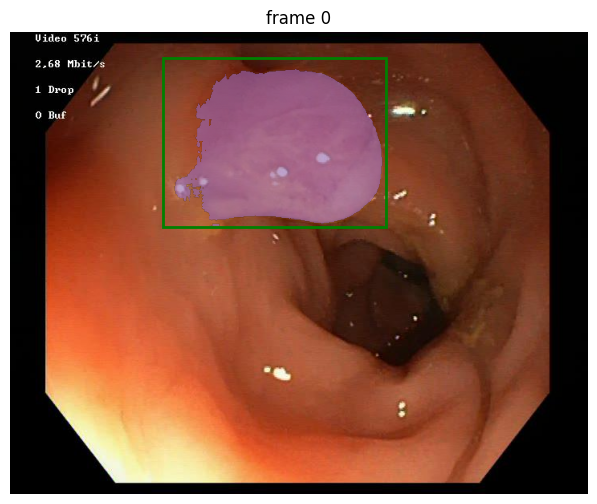

In [38]:
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

# Assuming show_box and show_mask are defined elsewhere in your code

# Frame and object information
ann_frame_idx = 0  # the frame index we interact with
ann_obj_id = 4  # give a unique id to each object we interact with (it can be any integer)

# Move tensor to CPU and convert it to a 
box = xyxy.cpu().numpy().squeeze()  # Use .squeeze() to remove extra dimensions

# Cast it to a specific dtype if needed
box = box.astype(np.float32)
box = xyxy.cpu().numpy().squeeze()  # Use .squeeze() to remove extra dimensions

# Cast it to a specific dtype if needed
box = box.astype(np.float32)

# Box coordinates
#box = np.array([190.1250,  31.5000, 468.0000, 243.0000], dtype=np.float32)

# Interact with the predictor (assumes the existence of a predictor and inference_state)
_, out_obj_ids, out_mask_logits = predictor.add_new_points_or_box(
    inference_state=inference_state,
    frame_idx=ann_frame_idx,
    obj_id=ann_obj_id,
    box=box,
)

# Load the image and ensure it's in RGB format
img = Image.open(os.path.join(video_dir, frame_names[ann_frame_idx])).convert("RGB")

# Show the results on the current (interacted) frame
plt.figure(figsize=(9, 6))
plt.title(f"frame {ann_frame_idx}")
plt.imshow(img)

# Display the bounding box
show_box(box, plt.gca())

# Display the mask with proper handling of the mask logits
mask = (out_mask_logits[0] > 0.5).cpu().numpy()
show_mask(mask, plt.gca(), obj_id=out_obj_ids[0])

# Optionally, remove axes for a cleaner visualization
plt.axis('off')

# Show the plot
plt.show()


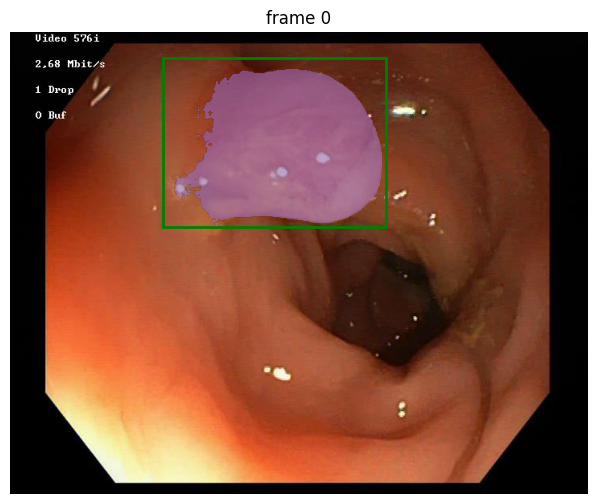

In [40]:
ann_frame_idx = 0  # the frame index we interact with
ann_obj_id = 4  # give a unique id to each object we interact with (it can be any integers)

# Let's add a box at (x_min, y_min, x_max, y_max) = (300, 0, 500, 400) to get started
#box = np.array([190.1250,  31.5000, 468.0000, 243.0000], dtype=np.float32)
_, out_obj_ids, out_mask_logits = predictor.add_new_points_or_box(
    inference_state=inference_state,
    frame_idx=ann_frame_idx,
    obj_id=ann_obj_id,
    box=box,
)
# Load the image and ensure it's in RGB format
img = Image.open(os.path.join(video_dir, frame_names[ann_frame_idx])).convert("RGB")

# Show the results on the current (interacted) frame
plt.figure(figsize=(9, 6))
plt.title(f"frame {ann_frame_idx}")
plt.imshow(img)

# show the results on the current (interacted) frame

show_box(box, plt.gca())
show_mask((out_mask_logits[0] > 0.0).cpu().numpy(), plt.gca(), obj_id=out_obj_ids[0])
plt.axis('off')

# Show the plot
plt.show()

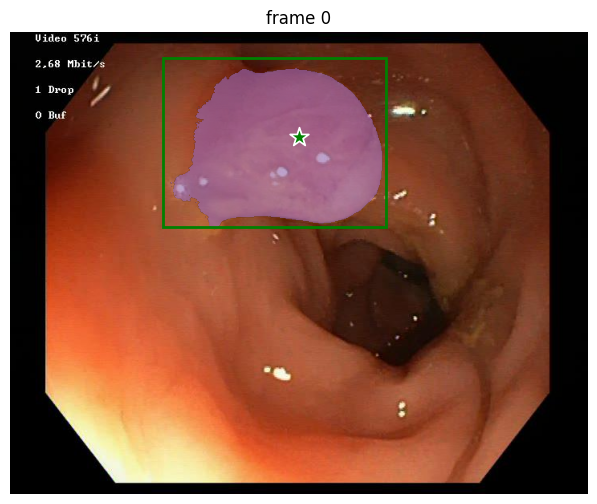

In [45]:
ann_frame_idx = 0  # the frame index we interact with
ann_obj_id = 4  # give a unique id to each object we interact with (it can be any integers)

# Let's add a positive click at (x, y) = (460, 60) to refine the mask
points = np.array([[360, 130]], dtype=np.float32)
# for labels, `1` means positive click and `0` means negative click
labels = np.array([1], np.int32)
# note that we also need to send the original box input along with
# the new refinement click together into `add_new_points_or_box`
#box = np.array([190.1250,  31.5000, 468.0000, 243.0000], dtype=np.float32)
_, out_obj_ids, out_mask_logits = predictor.add_new_points_or_box(
    inference_state=inference_state,
    frame_idx=ann_frame_idx,
    obj_id=ann_obj_id,
    points=points,
    labels=labels,
    box=box,
    
)

# show the results on the current (interacted) frame
plt.figure(figsize=(9, 6))
plt.title(f"frame {ann_frame_idx}")
plt.imshow(Image.open(os.path.join(video_dir, frame_names[ann_frame_idx])))
show_box(box, plt.gca())
show_points(points, labels, plt.gca())
show_mask((out_mask_logits[0] > 0.0).cpu().numpy(), plt.gca(), obj_id=out_obj_ids[0])
plt.axis('off')
plt.show()

In [46]:
import gc
gc.collect()


1473282

In [47]:
import cv2
import os

# Directory to save the output frames
output_dir = "path/to/output_frames_first3"
os.makedirs(output_dir, exist_ok=True)  # Create the directory if it doesn't exist

video_segments = {}  # video_segments contains the per-frame segmentation results
for out_frame_idx, out_obj_ids, out_mask_logits in predictor.propagate_in_video(inference_state):
    video_segments[out_frame_idx] = {
        out_obj_id: (out_mask_logits[i] > 0.0).cpu().numpy()
        for i, out_obj_id in enumerate(out_obj_ids)
    }

# render the segmentation results every few frames
vis_frame_stride = 1
plt.close("all")
for out_frame_idx in range(0, len(frame_names), vis_frame_stride):
    # Create a figure for each frame
    plt.figure(figsize=(6, 4))
    plt.title(f"frame {out_frame_idx}")
    
    # Load the original frame
    img = Image.open(os.path.join(video_dir, frame_names[out_frame_idx])).convert("RGB")
    plt.imshow(img)
    plt.axis('off')

    # Overlay segmentation masks
    for out_obj_id, out_mask in video_segments[out_frame_idx].items():
        show_mask(out_mask, plt.gca(), obj_id=out_obj_id)
    
    plt.axis('off')
    
    # Save the figure (frame) to the output directory
    output_path = os.path.join(output_dir, f"frame_{out_frame_idx:04d}.png")
    plt.savefig(output_path, bbox_inches='tight', pad_inches=0)
    plt.close()

print(f"Frames saved to {output_dir}")


propagate in video: 100%|██████████| 208/208 [09:14<00:00,  2.67s/it]


Frames saved to path/to/output_frames_first3


propagate in video: 100%|██████████| 50/50 [01:19<00:00,  1.60s/it]


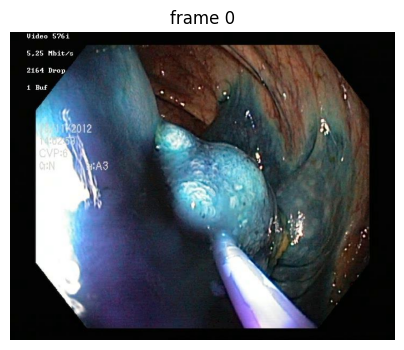

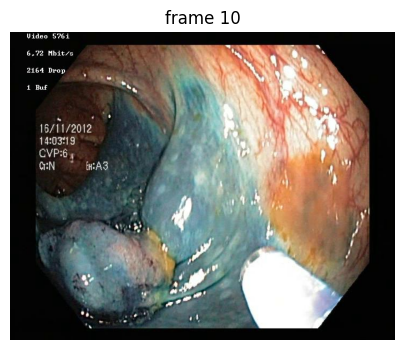

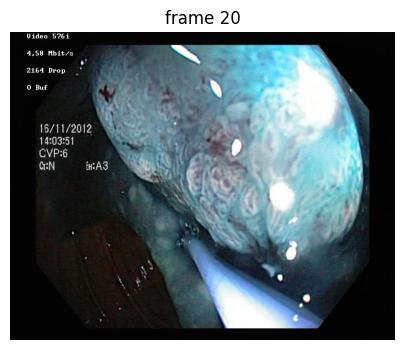

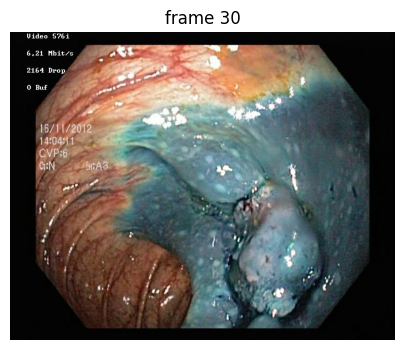

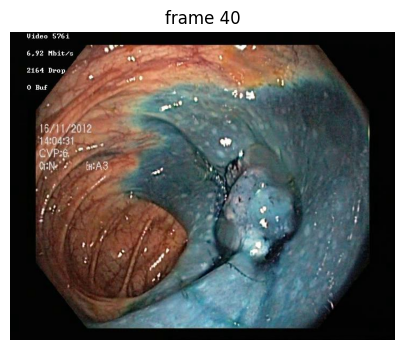

In [64]:
# run propagation throughout the video and collect the results in a dict
video_segments = {}  # video_segments contains the per-frame segmentation results
for out_frame_idx, out_obj_ids, out_mask_logits in predictor.propagate_in_video(inference_state):
    video_segments[out_frame_idx] = {
        out_obj_id: (out_mask_logits[i] > 0.0).cpu().numpy()
        for i, out_obj_id in enumerate(out_obj_ids)
    }

# render the segmentation results every few frames
vis_frame_stride = 10
plt.close("all")
for out_frame_idx in range(0, len(frame_names), vis_frame_stride):
    plt.figure(figsize=(6, 4))
    plt.title(f"frame {out_frame_idx}")
    plt.imshow(Image.open(os.path.join(video_dir, frame_names[out_frame_idx])).convert("RGB"))
    plt.axis('off')

    
    for out_obj_id, out_mask in video_segments[out_frame_idx].items():

        show_mask(out_mask, plt.gca(), obj_id=out_obj_id)
        plt.axis('off')
        plt.show()  


In [31]:
# convert Video to Frame
import imageio
import os

# Define the path to the video file
video_file = "C:/Users/39327/Desktop/test/1/Kvasir1.avi"

# Define the output directory for the frames
output_dir = 'output_frames_first2'

# Create the output directory if it doesn't exist
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Load the video
video_reader = imageio.get_reader(video_file)

# Get the frame rate
fps = video_reader.get_meta_data()['fps']
print(f"Original frame rate of the video: {fps} frames per second")

# Calculate the interval to extract frames at 5.0 fps
frame_interval = int(fps / 1.0)

# Loop over frames in the video and save every nth frame
for i, frame in enumerate(video_reader):
    if i % frame_interval == 0:
        frame_filename = os.path.join(output_dir, f"{i:05d}.jpg")
        imageio.imwrite(frame_filename, frame)

print(f"Frames extracted successfully to '{output_dir}' at 5.0 frames per second")


Original frame rate of the video: 25.0 frames per second
Frames extracted successfully to 'output_frames_first2' at 5.0 frames per second


In [48]:
import cv2
import os

# Define the directory containing the frames
frames_dir = "C:/Users/39327/Desktop/test/path/to/output_frames_first3" # Update this path to your directory
output_video_path = "output_video1.mp4"  # Output video file

# Get all the frame files and sort them by filename (assuming filenames are ordered)
frame_files = sorted([f for f in os.listdir(frames_dir) if f.endswith(('.jpg', '.jpeg', '.JPG', '.JPEG','png'))])

# Read the first frame to determine the size of the video
first_frame = cv2.imread(os.path.join(frames_dir, frame_files[0]))
height, width, layers = first_frame.shape

# Define the codec and create a VideoWriter object
fourcc = cv2.VideoWriter_fourcc(*'mp4v')  # Codec for mp4
fps = 1 # Frames per second
video = cv2.VideoWriter(output_video_path, fourcc, fps, (width, height))

# Loop through all the frames and add them to the video
for frame_file in frame_files:
    frame = cv2.imread(os.path.join(frames_dir, frame_file))
    video.write(frame)

# Release the video writer object
video.release()

print(f"Video created successfully at {output_video_path}")


Video created successfully at output_video1.mp4
